In [86]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score , classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
from keras import layers
from keras import activations



In [22]:

def split_data_target( dataframe , target_column : str ):

    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    return X , y

def convert_from_str_to_int(string_list : list , conversion_dict : dict):

    """
        This function takes a convertion dictionary : { "Famale" : 1 , "Male" : 0}
        and for every element in the string_list, converts it according to this dictionaty
    """

    new_list = []
    for item in string_list:
        new_list.append(conversion_dict[item])
    
    return new_list

def df_to_list(df):
    # Convert the dataframe to a NumPy array
    df_keys = list(df.keys())

    list_of_lists = []


    for i in range(len(df)):
        cur_list = []
        for k in df_keys:
            cur_list.append(df[k][i])
        
        list_of_lists.append(cur_list)
    
    return list_of_lists

def genarate_model( 
    n_list : list , 
    activations_list : list ,
    input_dim : int , 
    input_activation_function : str = "relu" ,
    output_node_number : int = 1,
    output_activation_function : str = "sigmoid",
    model_visualization : bool = False, 
    model_summary : bool = False, 
    first_hidden_layer : int = 50,
    ):

    # Define the model architecture
    model = Sequential()

    model.add(Dense(first_hidden_layer , input_dim=input_dim, activation=input_activation_function))

    for node , act_function in zip(n_list , activations_list):
        model.add(Dense(node, activation=act_function))
        
    
        
    model.add(Dense(output_node_number, activation=output_activation_function))


    if model_summary:
        print(model.summary())
    if model_visualization:
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        plt.show('model_plot.png')



    return model

def find_best_model_fit(model , num_of_iters : int = 1):
    
    best_model = None
    best_acc = 0
    best_history = None

    acc_list = []

    for _ in range(num_of_iters):
            
        # train the model (using the validation set)
        history = model.fit(X_train_norm , y_train , validation_data=(X_validation_norm , y_validation) , epochs = epoch_number , verbose=0)

        # making a prediction
        y_pred_prob_nn_1 = model.predict(X_test_norm)
        y_pred_class_nn_1 = np.rint(y_pred_prob_nn_1)


        cur_acc = accuracy_score(y_test,y_pred_class_nn_1)

        acc_list.append(cur_acc)
        
        if cur_acc > best_acc:
            best_acc = cur_acc
            best_model = model
            best_history = history
        
    print(acc_list)
    print("Best model accuracy : " , best_acc)
    return best_model , best_history




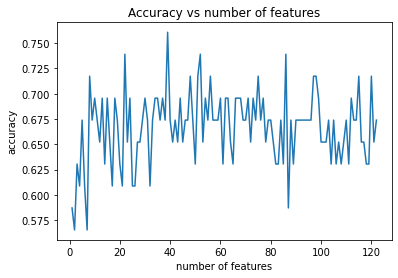


Using 39 features out of 123

1. NM_025099
2. NM_020725
3. NM_138281
4. NM_032531
5. NM_032943
6. NM_001136498
7. NM_020746
8. NM_001882
9. NM_170672
10. NM_001244
11. NM_002753
12. NM_015497
13. NM_014280
14. NM_001029864
15. NM_145345
16. NM_005795
17. NM_001143820
18. NM_033396
19. NM_002399
20. NM_018316
21. NM_012311
22. NM_001860
23. NM_006336
24. NM_032753
25. NM_000681
26. NM_001626
27. NM_001039771
28. NM_001011552
29. NM_003946
30. NM_001287444
31. NM_024751
32. NM_007210
33. NM_030973
34. NM_003592
35. age
36. NM_001308147
37. NM_198552
38. NM_001204269
39. NM_001099221


In [84]:

train_data = pd.read_csv("https://raw.githubusercontent.com/ofryma/intro-to-AI/main/hw/data_mining_project/cancer_dignose/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/ofryma/intro-to-AI/main/hw/data_mining_project/cancer_dignose/testing.csv")
validation_data = pd.read_csv("https://raw.githubusercontent.com/ofryma/intro-to-AI/main/hw/data_mining_project/cancer_dignose/validation.csv")

# aplit the data to X and y
X_train , y_train = split_data_target(train_data , "Diagnosis")
X_test , y_test = split_data_target(test_data , "Diagnosis")
X_validation , y_validation = split_data_target(validation_data , "Diagnosis")

# convert the string columns into integer columns
X_train["gender"] = convert_from_str_to_int(X_train["gender"] , {"Female" : 1 , "Male" : 0})
y_train = convert_from_str_to_int(y_train , {"NonCancer" : 0 , "Cancer" : 1})
X_test["gender"] = convert_from_str_to_int(X_test["gender"] , {"Female" : 1 , "Male" : 0})
y_test = convert_from_str_to_int(y_test , {"NonCancer" : 0 , "Cancer" : 1})
X_validation["gender"] = convert_from_str_to_int(X_validation["gender"] , {"Female" : 1 , "Male" : 0})
X_validation = X_validation.drop(columns=["PtNo"])
y_validation = convert_from_str_to_int(y_validation , {"NonCancer" : 0 , "Cancer" : 1})



# Implament feature selection using random forest
fs_n = []
fs_acc = []
best_acc = 0
best_n = 0
original_len = len(X_train.keys())
best_top_features = []

clf = RandomForestClassifier(n_estimators=len(X_train.keys()), random_state=0)
clf.fit(X_train, y_train)
importances = clf.feature_importances_

# searching all the possible numbers for the best accuracy
for n in range(1 , len(X_train.keys())):
  fs_n.append(n)
  top_n_features = importances.argsort()[-n:]
  X_train_top = {}
  X_test_top = {}
  X_validation_top = {}

  for feature in top_n_features:
    f_name = list(X_train.keys())[feature]
    X_train_top[f_name] = X_train[f_name]
    X_test_top[f_name] = X_test[f_name]
    X_validation_top[f_name] = X_validation[f_name]


  X_train_top = pd.DataFrame.from_dict(X_train_top)
  X_test_top = pd.DataFrame.from_dict(X_test_top)
  X_validation_top = pd.DataFrame.from_dict(X_validation_top)
  
  clf2 = RandomForestClassifier(n_estimators=len(X_test_top.keys()), random_state=0)
  clf2.fit(X_train_top, y_train)
  
  y_pred = clf2.predict(X_test_top)
  acc = accuracy_score(y_pred , y_test)
  fs_acc.append(acc)

  if acc > best_acc:
    best_acc = acc
    best_n = n
    best_top_features = top_n_features 

  del clf2


# ploting the accuracy as a function of the number of features 
plt.plot(fs_n , fs_acc)
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('Accuracy vs number of features')
plt.show()

print(f"\nUsing {best_n} features out of {original_len}\n")


# changing the data to match the best feature selection
for index , feature in enumerate(best_top_features):
  f_name = list(X_train.keys())[feature]
  print(f"{index+1}. {f_name}")
  X_train_top[f_name] = X_train[f_name]
  X_test_top[f_name] = X_test[f_name]
  X_validation_top[f_name] = X_validation[f_name]

X_train = pd.DataFrame.from_dict(X_train_top)
X_test = pd.DataFrame.from_dict(X_test_top)
X_validation = pd.DataFrame.from_dict(X_validation_top)


# converting the dataframes into list of all the rows in the dataframe
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_validation_norm = normalizer.transform(X_validation)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_validation = np.asarray(y_validation)



In [72]:
# variables
input_dim = len(list(X_train.keys()))
epoch_number = 100
n_list = [100 , 80] # number of nodes in each hidden layer
activations_list = ["relu" , "relu"] # activation function in each hidden layer
learning_rate = 0.003
momentum = 0.9
find_model_tries = 4 # nmber of times to run the model.fit before getting back the best one


model = genarate_model(
    n_list=n_list,
    activations_list=activations_list,
    input_dim=input_dim,
    model_summary = True,
    model_visualization=True,
)

# Compile the model
model.compile(SGD(lr = learning_rate, momentum=momentum), loss='binary_crossentropy', metrics=['accuracy'])


# find the best model
model , history = find_best_model_fit(model , find_model_tries)




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 50)                6150      
                                                                 
 dense_42 (Dense)            (None, 100)               5100      
                                                                 
 dense_43 (Dense)            (None, 80)                8080      
                                                                 
 dense_44 (Dense)            (None, 1)                 81        
                                                                 
Total params: 19,411
Trainable params: 19,411
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 6ms/step
[0.6956521739130435, 0.6956521739130435, 0.6956521739130435, 0.6956521739130435]
Best model accuracy :  0.6956521739130435


## Use KNN model for compare

We can use the KNN model from HW2 to compare with our neural network model.

In [92]:
, recall_score
import math
import pandas as pd
from pandas import read_csv
import numpy as np
import operator

# importing the hamming and euclidean distance functions
from scipy.spatial.distance import hamming , euclidean

# also found a function for calculating manhattan distance
def manhattan(p, q):
    """ 
    Return the manhattan distance between points p and q
    assuming both to have the same number of dimensions
    """
    # sum of absolute difference between coordinates
    distance = 0
    for p_i,q_i in zip(p,q):
        distance += abs(p_i - q_i)
    return distance

# creating a basic class for saving the distance for every point
# in the data while saving the related tag (target) value 
class myDist():
  def __init__(self , dist  : int , tag : str):
    self.dist = dist
    self.tag = tag


def my_classify( data , target , point , k = 1  , dist_calc_method = "e"):
  """
  This function classify an unknown point based on three methods of calculation:
  1. euclidean
  2. manhattan
  3. hamming

  The function takes a data metrix, target vector, point vector with the same
  length the lists in the data and try to predict the tag for the given point
  """
  

  results = {}
  cls_list = []
  method = dist_calc_method

  if method == "e":
    the_method = "euclidean"
  if method == "m":
    the_method = "manhattan"
  if method == "h":
    the_method = "hamming"

  ###################################
  # calculating the distances
  for d , t in zip(data,target):
    if method == "e":
      dist = euclidean(d , point)
    elif method == "m":
      dist = manhattan(d , point)
    elif method == "h":
      dist = hamming(d , point)
    else:
      dist = euclidean(d , point)
    
    cls_list.append(myDist(dist , t))
    results[t] = 0
  
  ###################################
  # sorting the list
  cls_list.sort(key=operator.attrgetter('dist'))

  # calculate the number of each target for classifing the unknown point's target
  for i in range(k):
    cur_my_dist = cls_list[i]
    try:
      # print(f"{i+1}. {cls_list[i].dist} , {cls_list[i].tag}")
      results[cur_my_dist.tag] += 1
    except:
      pass

  m = max(results.values())
  index = list(results.values()).index(m)
  prediction = list(results.keys())[index]

  return prediction , the_method




def knn_model(train_data , train_tags , test_data , test_tags , knn = 3 ,clac_method = "e"):
  """
  This function use a train and test datasets, and for a given k and calculation method [e,m,h]
  finding a predicted tag for each point in the test data set. It counts the number of correct
  predictions and returns the accuracy of the model and the distance calculation method used
  """

  correct = 0
  tries = 0
  y_pred = []

  for point , tag in zip(test_data , test_tags):
    # using the function from the warmup section
    prd , used = my_classify(train_data , train_tags , point , k=knn , dist_calc_method=clac_method)
    y_pred.append(prd)
    #calculate the accuracy - checking for a correct prediction
    if prd == tag:
      correct += 1
    tries +=1
  

  acc = accuracy_score(test_tags, y_pred)
  report = classification_report(test_tags, y_pred)
  
  return report , used , acc




# checking for every calculation method with three k
methods = ["e" ,"m" ,"h"]
knns = [1,5,15]

config = {
    "best_k" : None,
    "best_knn_acc" : 0,
    'best_report' : None,
    "best_used_method" : None,
}


for mt in methods:
  for knn in knns:
    report , used_method , cur_acc = knn_model(X_train_norm , y_train , X_test_norm , y_test , knn=knn , clac_method =mt)
    if cur_acc > config["best_knn_acc"]:
      config = {
          "best_k" : knn,
          "best_knn_acc" : cur_acc,
          'best_report' : "\n" + report,
          "best_used_method" : used_method,
      }

for key in config.keys():
  print(f"{key} : {config[key]}")



best_k : 15
best_knn_acc : 0.6739130434782609
best_report : 
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        29
           1       1.00      0.12      0.21        17

    accuracy                           0.67        46
   macro avg       0.83      0.56      0.50        46
weighted avg       0.79      0.67      0.58        46

best_used_method : euclidean
